In [2]:
import sys
sys.path.append('..')
from sklearn.model_selection import train_test_split

import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import random
import utils
import pandas as pd
import os

/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numba/core/types/__init__.py:108: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  long_ = _make_signed(np.long)
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numba/core/types/__init__.py:108: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  long_ = _make_signed(np.long)


In [2]:
expName = 'compare'

dir = '../datasets/%s.pickle' % expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[-1]
tag = 'SSVEP'
# chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ', 'O2']
chnNames = sub['channel']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub[tag]['X'][:, chnINX]
y = sub[tag]['y']
S = sub[tag]['STI']
sub['name']

'zhouyuqing'

In [8]:
srate = 250
winLEN = 0.3
tmin=0
tmax=0.3
targtetNUM = 40

In [9]:
from spatialFilters import TDCA
X = X-np.mean(X,axis=-1,keepdims=True)
model = TDCA(n_components=1,n_band=1,montage=targtetNUM,lag=0.14,srate=250,winLEN=winLEN)
evokeds = model.fit_transform(X,y)
X_ = model.filter(X)

In [10]:
from scipy import signal

snrs = np.zeros((40,8))
N = 75
_classes = np.unique(y)

for i,(evoked,_class) in enumerate(zip(evokeds,_classes)):
    
    epochs = X_[ y == _class ]

    for j,epoch in enumerate(epochs):

        noise = epoch-evoked
                    
        s = np.abs(np.fft.fftshift(np.fft.fft(evoked,axis=-1)/N))**2
        san = np.abs(np.fft.fftshift(np.fft.fft(epoch,axis=-1)/N))**2
        n = np.abs(np.fft.fftshift(np.fft.fft(noise, axis=-1)/N))**2

        # break
        s_power = np.sum(s[:,N//2:],axis=-1)
        all_power = np.sum(san[:,N//2:],axis=-1)
        n_power = np.sum(n[:,N//2:],axis=-1)

        snrs[i,j] = 10*np.log10(s_power/n_power)


In [ ]:
expName = 'compare'

srate = 250
winLEN = 0.5

tmin = 0
tmax = 0.3

key = 'WN'
dir = '../datasets/%s.pickle' % expName
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[-2]
chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ', 'O2', 'PO3']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub[key]['X'][:, chnINX]
y = sub[key]['y']
S = sub[key]['STI']
_class = np.unique(y).tolist()
sub['name']

In [5]:
snrs = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'snr.csv'):
        f = pd.read_csv(subFolder+os.sep+'snr.csv')
        snrs.append(f)

snrs = pd.concat(snrs, ignore_index=True)
snrs.head()

,Unnamed: 0,snr,epoch,class,method,subject
0,0,-13.898081,0,0,WN,yangyuxing
1,1,-3.741933,1,0,WN,yangyuxing
2,2,1.490836,2,0,WN,yangyuxing
3,3,0.351946,3,0,WN,yangyuxing
4,4,-1.947051,4,0,WN,yangyuxing


<AxesSubplot: xlabel='class', ylabel='snr'>

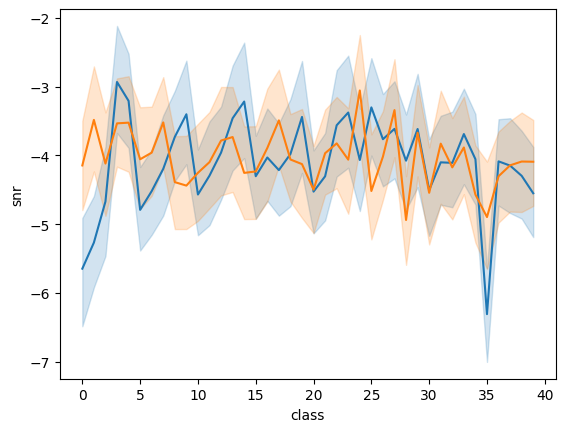

In [8]:
list = ['yangyuxing', 'jingyi','xuwenjia',
        'fanzixiao', 'wangchaoying', 'lijiayang', 
        'libowen', 'zhouyuqing', 'miaoyining', 
        'yaofeifan','chenyuzhen','shixinge',
        'suxiaohan','quyuxin','zhaoxinyu',
        'jiaqi']


sns.lineplot(data=snrs[(snrs.subject.isin(list))&(snrs.method=='SSVEP')],x='class',y='snr')

sns.lineplot(data=snrs[(snrs.subject.isin(list))&(snrs.method=='WN')],x='class',y='snr')

<AxesSubplot: xlabel='Density', ylabel='snr'>

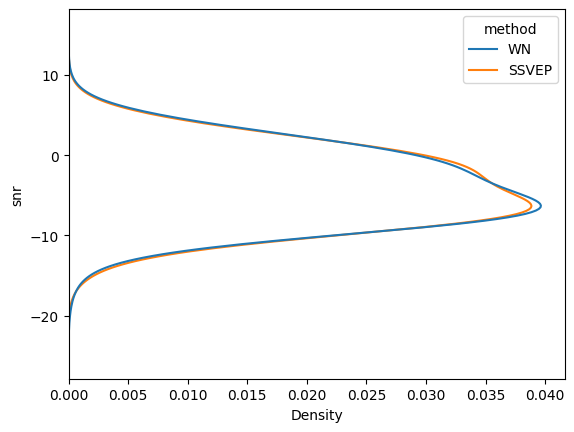

In [13]:
sns.kdeplot(data=snrs[snrs.subject.isin(list)], y='snr', hue='method',bw_adjust=3)